In [1]:
import json
import pandas as pd
import re
from datetime import datetime

# Load Apify exported JSON data
with open('/content/tweets dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Create tweets list
tweets_list = []

# Process data structure
for item in data:
    # Check if it's a tweet object
    if 'full_text' in item or 'text' in item:
        tweet = item
    else:
        continue

    # Extract basic information
    tweet_data = {
        'id': tweet.get('id_str') or tweet.get('id'),
        'created_at': tweet.get('created_at'),
        'text': tweet.get('full_text') or tweet.get('text', ''),
        'retweet_count': tweet.get('retweet_count', 0),
        'favorite_count': tweet.get('favorite_count', 0),
        'reply_count': tweet.get('reply_count', 0),
        'lang': tweet.get('lang', ''),
        'source': tweet.get('source', '')
    }

    # Extract user information
    if 'user' in tweet:
        tweet_data.update({
            'user_id': tweet['user'].get('id_str') or tweet['user'].get('id'),
            'username': tweet['user'].get('screen_name', ''),
            'user_name': tweet['user'].get('name', ''),
            'user_followers': tweet['user'].get('followers_count', 0),
            'user_location': tweet['user'].get('location', '')
        })

    # Extract quote or reply information
    tweet_data['is_reply'] = tweet.get('in_reply_to_status_id') is not None
    tweet_data['is_quote'] = tweet.get('is_quote_status', False)

    # Extract media information
    if 'entities' in tweet and 'media' in tweet['entities']:
        tweet_data['has_media'] = True
        tweet_data['media_type'] = tweet['entities']['media'][0].get('type', '')
    else:
        tweet_data['has_media'] = False
        tweet_data['media_type'] = ''

    # Extract hashtags
    if 'entities' in tweet and 'hashtags' in tweet['entities']:
        tweet_data['hashtags'] = [h['text'] for h in tweet['entities']['hashtags']]
    else:
        tweet_data['hashtags'] = []

    tweets_list.append(tweet_data)

# Create DataFrame
df = pd.DataFrame(tweets_list)

# Data cleaning
def clean_text(text):
    """Clean tweet text"""
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove user tags (@user)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (#topic)
    text = re.sub(r'#\w+', '', text)

    # Remove RT prefix
    text = re.sub(r'^rt\s+', '', text)

    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Remove empty text and duplicates
df = df[df['clean_text'] != ''].drop_duplicates(subset=['clean_text']).reset_index(drop=True)

# Convert date format
try:
    df['created_at'] = pd.to_datetime(df['created_at'])
except:
    # If standard conversion fails, try specific format
    df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

# Save processed data
df.to_csv('starbucks_twitter_processed.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/content/tweets dataset.json'

In [9]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK resources
nltk.download('vader_lexicon')

# Initialize analyzer
sia = SentimentIntensityAnalyzer()

# Analyze sentiment
def analyze_sentiment(text):
    """Analyze text sentiment"""
    if not isinstance(text, str) or not text:
        return {
            'compound': 0,
            'neg': 0,
            'neu': 0,
            'pos': 0,
            'sentiment': 'neutral'
        }

    # Get sentiment scores
    scores = sia.polarity_scores(text)

    # Determine sentiment category based on compound score
    if scores['compound'] >= 0.05:
        sentiment = 'positive'
    elif scores['compound'] <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'

    scores['sentiment'] = sentiment
    return scores

# Apply sentiment analysis
sentiment_results = df['clean_text'].apply(analyze_sentiment)
sentiment_df = pd.json_normalize(sentiment_results)
df = pd.concat([df, sentiment_df], axis=1)

# Sentiment distribution statistics
sentiment_counts = df['sentiment'].value_counts()
print("\nSentiment Distribution:")
for sentiment, count in sentiment_counts.items():
    percentage = count / len(df) * 100
    print(f"{sentiment}: {count} ({percentage:.1f}%)")

# Average sentiment score
avg_sentiment = df['compound'].mean()
print(f"\nAverage Sentiment Score: {avg_sentiment:.4f}")

# Save data with sentiment analysis
df.to_csv('starbucks_twitter_with_sentiment.csv', index=False)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Sentiment Distribution:
positive: 2105 (43.8%)
negative: 1435 (29.8%)
neutral: 1270 (26.4%)

Average Sentiment Score: 0.0912


In [12]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from collections import Counter

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the missing 'punkt_tab' resource

# Load stopwords
stop_words = set(stopwords.words('english'))

# Add Twitter and Starbucks-specific stopwords
stop_words.update(['rt', 'like', 'amp', 'im', 'u', 'starbucks', 'coffee'])

# Extract all words
all_words = []
for text in df['clean_text']:
    if isinstance(text, str):
        words = word_tokenize(text)
        # Filter stopwords and short words
        filtered_words = [word.lower() for word in words if word.lower() not in stop_words and len(word) > 2]
        all_words.extend(filtered_words)

# Most common words
word_counts = Counter(all_words)
top_words = word_counts.most_common(20)
print("\nMost Common Words:")
for word, count in top_words:
    print(f"{word}: {count}")

# Analyze keywords by sentiment category
positive_tweets = df[df['sentiment'] == 'positive']['clean_text']
negative_tweets = df[df['sentiment'] == 'negative']['clean_text']

print("\nTop Words in Positive Comments:")
for word, count in Counter([w for text in positive_tweets for w in word_tokenize(text)
                          if w.lower() not in stop_words and len(w) > 2]).most_common(10):
    print(f"{word}: {count}")

print("\nTop Words in Negative Comments:")
for word, count in Counter([w for text in negative_tweets for w in word_tokenize(text)
                          if w.lower() not in stop_words and len(w) > 2]).most_common(10):
    print(f"{word}: {count}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Most Common Words:
dont: 513
get: 482
people: 402
cup: 392
make: 362
drink: 346
one: 318
buy: 293
good: 284
would: 242
time: 234
better: 234
even: 212
going: 211
shop: 203
got: 202
thats: 202
never: 199
home: 194
day: 189

Top Words in Positive Comments:
get: 230
dont: 230
good: 229
better: 197
people: 194
make: 186
cup: 182
one: 166
buy: 148
drink: 145

Top Words in Negative Comments:
dont: 214
people: 165
get: 163
drink: 131
cup: 122
make: 118
one: 101
buy: 97
pay: 89
would: 88


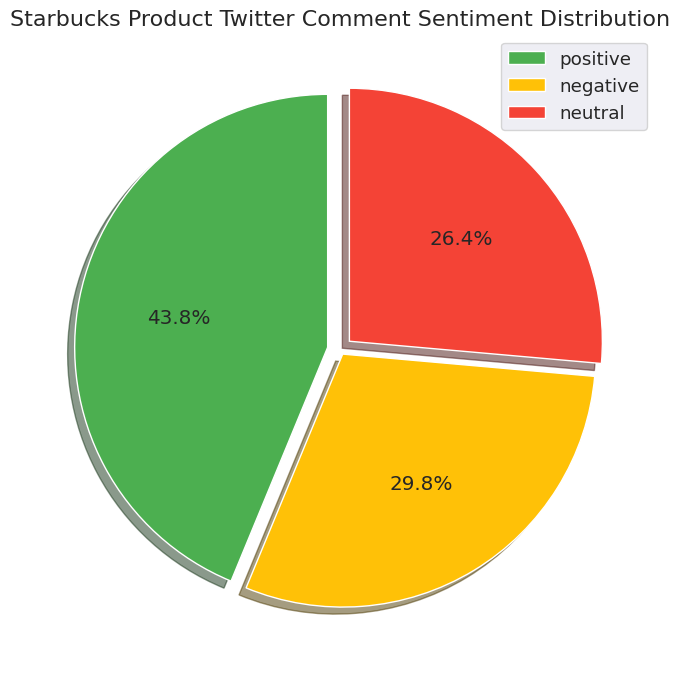

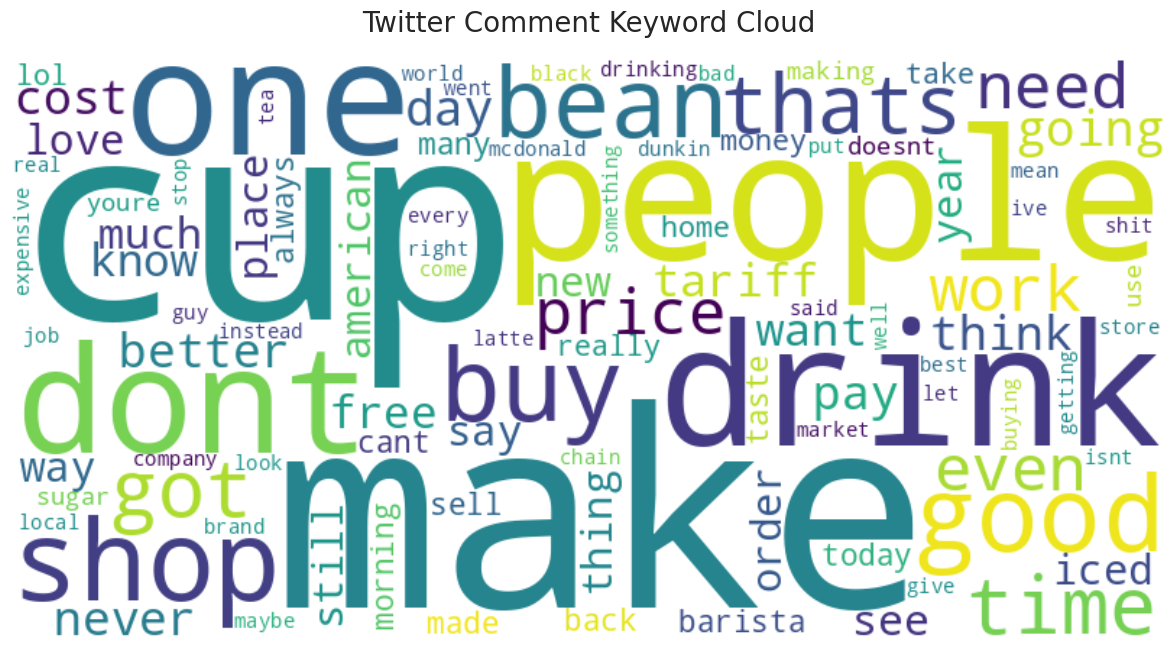

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from matplotlib.dates import DateFormatter
import calendar

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# 1. Sentiment Distribution Pie Chart
plt.figure(figsize=(10, 7))
colors = ['#4CAF50', '#FFC107', '#F44336']  # Green, Yellow, Red
sentiment_counts.plot.pie(
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.05, 0.02, 0.05],
    shadow=True,
    startangle=90,
    labels=None
)
plt.title('Starbucks Product Twitter Comment Sentiment Distribution', fontsize=16)
plt.ylabel('')
plt.legend(sentiment_counts.index, loc="best")
plt.tight_layout()
plt.savefig('twitter_sentiment_distribution.png', dpi=300, bbox_inches='tight')

# 2. Word Cloud
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100,
    contour_width=3,
    contour_color='steelblue'
).generate(' '.join(all_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Twitter Comment Keyword Cloud', fontsize=20, pad=20)
plt.tight_layout()
plt.savefig('twitter_wordcloud.png', dpi=300, bbox_inches='tight')